In [ ]:
! pip install skan

In [ ]:
import math
import time

import numpy as np
import skan.csr
from imageio import imread
from matplotlib import pyplot as plt
from scipy import ndimage, stats
from scipy.ndimage import label
from skan import skeleton_to_csgraph
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.morphology import medial_axis
from skimage.morphology import skeletonize
# Skeleton, skeleton_to_csgraph
# https://jni.github.io/skan/api/skan.csr.html


# @numba.jit(nopython=True, parallel=True)


# For animating later
# time.sleep(5)

In [ ]:
def scale_to_range(vals):
  return (vals * (255.0/vals.max()))

In [ ]:
def compute_gradients(img):
    """
    Computes the gradients of the input image in the x and y direction using a 
    differentiation filter.
    
    Differention filter uses Prewitt's preset
    
    Input: Grayscale image of shape (H x W)
    Outputs: gx, gy gradients in x and y directions respectively
    
    """
    
    mx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    my = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    gx = ndimage.correlate(img, mx, mode="constant", cval=0)
    gy = ndimage.correlate(img, my, mode="constant", cval=0)
    
    return gx, gy

In [ ]:
initial_trim_factor = 2.0
trim_step = 0.1

def medial_axis_trim(skeleton, distance):

    # below doesnt use a chain of modifications only modfies orignal just by a different ammount so just compute this ahead
    dist_on_skel = distance * skeleton
    medial_axis_mode, _ = stats.mode(dist_on_skel[dist_on_skel >= 1.0], axis=None)

    # take initial count of how may segments there are
    labeled_skeleton, _ = label(skeleton, structure=[[1, 1, 1], [1, 1, 1], [1, 1, 1]])
    vals, _ = np.unique(labeled_skeleton, return_counts=True)
    initial_size = vals.size
    current_size = initial_size

    trimmed_skeleton = np.array([])
    current_skeleton = np.copy(skeleton)
    trim_factor = initial_trim_factor

    # if the this statement fails you will exit with trimmed_skeleton being the most trimming with out reducing the number of segments 
    while (initial_size == current_size):
        trimmed_skeleton = np.copy(current_skeleton)
        current_skeleton = np.copy(skeleton)

        trim_factor = trim_factor - trim_step

        trim_threshold = medial_axis_mode - np.std(dist_on_skel[dist_on_skel >= 1.0])*trim_factor
        current_skeleton = np.where(dist_on_skel > trim_threshold, current_skeleton, 0)

        labeled_skeleton, _ = label(current_skeleton, structure=[[1, 1, 1], [1, 1, 1], [1, 1, 1]])
        vals, _ = np.unique(labeled_skeleton, return_counts=True)
        current_size = vals.size


    return trimmed_skeleton, medial_axis_mode, dist_on_skel

In [ ]:
def path_cut(skeleton):
    '''
    Given skeleton image trim the shortest edge from all degree 3 nodes if a degree 3 node exists
    '''
   
    # check if degree 3 nodes even exist
    pixel_graph, node_coords, degree_map = skeleton_to_csgraph(skeleton, unique_junctions=False)
    degree_map = degree_map.astype(np.int)
    vals, counts = np.unique(degree_map, return_counts=True)
    
    if counts[np.nonzero(vals == 3)] != 0:
        print("Tree based trimming needed")
    else:
        # If no degree 3 node exists return early
        print("Tree based trimming not needed")
        return skeleton

    path_cut_skeleton = np.copy(skeleton)
    sk = skan.csr.Skeleton(path_cut_skeleton)


    # Alternative approach to path trimming since the other is causing many issues and it seems node to path is not working
    pixel_graph, node_coords, degree_map = skeleton_to_csgraph(skeleton, unique_junctions=False)
    degree_map = degree_map.astype(np.int)
    vals, counts = np.unique(degree_map, return_counts=True)
    
    while(counts[np.nonzero(vals == 3)] != 0):
    
        # Determine skan path membership to labeled clusters indexes
        labeled_skeleton, _ = label(path_cut_skeleton, structure=[[1, 1, 1], [1, 1, 1], [1, 1, 1]])
        cluster_ids, _ = np.unique(labeled_skeleton, return_counts=True)
        print(cluster_ids.size)

        cluster_to_path_ids = []
        for _ in range(cluster_ids.size):
            cluster_to_path_ids.append([])

        for path_id in range(sk.n_paths):
            # print("path_coordinates",sk.path_coordinates(path_id))
            path_coords = sk.path_coordinates(path_id).astype(np.int)
            cluster_mode, _ = stats.mode(labeled_skeleton[path_coords[:, 0], path_coords[:, 1]], axis=None)
            cluster_mode = cluster_mode[0]
            cluster_to_path_ids[cluster_mode].append(path_id) # for the most populous cluster labeling of the points in the path add this path id to that cluster labels list


        # For one cluster look at the assigned n paths and remove the shortest path
        
        # Find what clusters even have a degree 3 point
        row, column = np.nonzero(degree_map == 3)
        vals = np.unique(labeled_skeleton[row, column])

        # for each of these look at what paths consitute that cluster. Find the shortest one. And cut it.
        for cluster_id in vals:
            path_ids = np.array(cluster_to_path_ids[cluster_id])
            path_lengths = sk.path_lengths()[path_ids]
            path_to_cut = path_ids[np.argmin(path_lengths)]
            path_coords = sk.path_coordinates(path_to_cut).astype(np.int)
            path_cut_skeleton[path_coords[:, 0], path_coords[:, 1]] = 0.0
        
        # FIX SPLIT PATHS IF THEY OCCUR       
        pixel_graph, node_coords, degree_map = skeleton_to_csgraph(path_cut_skeleton, unique_junctions=False)
        degree_map = degree_map.astype(np.int)
        vals, counts = np.unique(degree_map, return_counts=True)




    # VISUALIZATION POST-TRIM
    pixel_graph, node_coords, degree_map = skeleton_to_csgraph(path_cut_skeleton, unique_junctions=False)
  
    row, column = np.nonzero(degree_map == 1)
    # VISUALIZATION for degree 1 vertices POST-TRIM
    # axs[1, 2].scatter(column, row, marker='o', color='green')

    row, column = np.nonzero(degree_map == 3)
    # VISUALIZATION for degree 3 verticies POST-TRIM
    axs[1,2].scatter(column, row, marker='o', color='red')

    return path_cut_skeleton

In [ ]:
def path_trim(skeleton):
    '''
    Given skeleton image trim the shortest edge from all degree 3 nodes if a degree 3 node exists
    '''
   
    # check if degree 3 nodes even exist
    pixel_graph, node_coords, degree_map = skeleton_to_csgraph(skeleton, unique_junctions=False)
    degree_map = degree_map.astype(np.int)
    vals, counts = np.unique(degree_map, return_counts=True)
    
    if counts[np.nonzero(vals == 3)] != 0:
        print("Tree based trimming needed")
    else:
        # If no degree 3 node exists return early
        print("Tree based trimming not needed")
        return skeleton

    path_cut_skeleton = np.copy(skeleton)
    sk = skan.csr.Skeleton(path_cut_skeleton)

    print("sk.n_paths", sk.n_paths)
    print("sk.path_lengths()", sk.path_lengths())

    labeled_skeleton, _ = label(skeleton, structure=[[1, 1, 1], [1, 1, 1], [1, 1, 1]])
    vals, _ = np.unique(labeled_skeleton, return_counts=True)
    num_to_cut = sk.n_paths - (vals.size - 1)

    indices_to_cut = np.argsort(sk.path_lengths())[:num_to_cut] # 25 best descriptors
    for cut_index in indices_to_cut:
        path_coords = sk.path_coordinates(cut_index).astype(np.int)
        path_cut_skeleton[path_coords[:, 0], path_coords[:, 1]] = 0.0

    # VISUALIZATION POST-TRIM
    pixel_graph, node_coords, degree_map = skeleton_to_csgraph(path_cut_skeleton, unique_junctions=False)
    print("sk.n_paths", sk.n_paths)
    print("sk.path_lengths()", sk.path_lengths())
  
    row, column = np.nonzero(degree_map == 1)
    # VISUALIZATION for degree 1 vertices POST-TRIM
    axs[1, 2].scatter(column, row, marker='o', color='green')
    print("degree 1 point count post-trim", row.size)

    row, column = np.nonzero(degree_map == 3)
    # VISUALIZATION for degree 3 verticies POST-TRIM
    axs[1,2].scatter(column, row, marker='o', color='red')
    print("degree 3 point count post-trim", row.size)

    return path_cut_skeleton

In [ ]:
def mod(a, b):
    """ Handles mod operations where the first operand is negative in a more sane way like in other
        programming languages.
        Source: https://torstencurdt.com/tech/posts/modulo-of-negative-numbers/
    """
    c = a % b

    print("c", c)
    return c + b if c < 0 else c


def fix_endpoint_gradients(skeleton, gradient_direction):
    """
    Find 1D endpoints of each curve and rotate the gradients to be pointing outwards
    :param skeleton a Skeleton image
    :return:
    """

    skel_copy = np.copy(skeleton)

    pixel_graph, node_coords, degree_map = skeleton_to_csgraph(skel_copy, unique_junctions=False)

    rows, columns = np.nonzero(degree_map == 1)

    endpoint_coords = np.column_stack((rows, columns))

    results = np.array([])
    for point in endpoint_coords:
        row = point[0]
        col = point[1]
        skel_copy[row, col] = 0  # mask the current pixel so we only return one result
        chunk = skel_copy[row - 1:row + 2, col - 1:col + 2]  # 3x3 window around the current pixel
        row_offset, col_offset = np.nonzero(chunk)

        # if row_offset.shape[0] == 0:
        #     axs[1, 2].scatter(col, row, marker='x', color='red')
        #     print("empty chunk")
        #     print("chunk", chunk)
        #     print("row, col", row, col)
        #     print("ro, co", row_offset, col_offset)
        #     continue

        if row_offset.shape[0] != 1:
            axs[1, 2].scatter(col, row, marker='x', color='red')
            print("-------")
            print("INAVID CHUNK")
            print("chunk", chunk)
            print("row, col", row, col)
            print("ro, co", row_offset, col_offset)
            continue

        angle = np.arctan2(row_offset - 1, col_offset - 1)[0]

        gradient_set = np.array([])
        gradient_set = np.append(gradient_set, gradient_direction[row, col])

        print("gradient_set", gradient_set)
        normal = np.mean(gradient_set)
        print("normal", normal)
        # print(normal - angle)
        tangent = mod(normal + np.pi / 2, 2 * np.pi)
        print("tangent", tangent)

        # tangent is pointing in the wrong direction, flip 180 deg
        if np.abs(tangent - angle) < np.pi / 2:
            tangent = mod(tangent - np.pi, 2 * np.pi)

        results = np.append(results, tangent)

        # VISUALIZATION normals (in the for loop printing out each one)
        axs[1, 2].quiver(col, 
                    row, 
                    ((4 * 15) * np.cos(normal)), 
                    ((4 * 15) * np.sin(normal)), color="red")

    return results

In [ ]:
def construct_endpoint_vectors(skeleton, fixed_endpoint_directions, medial_axis_mode):
    pixel_graph, node_coords, degree_map = skeleton_to_csgraph(skeleton, unique_junctions=False)

    rows, columns = np.nonzero(degree_map == 1)

    endpoint_coords = np.column_stack((rows, columns))

    vector_coords_cols = ((4 * medial_axis_mode) * np.cos(fixed_endpoint_directions)).astype(np.int)
    vector_coords_rows = ((4 * medial_axis_mode) * np.sin(fixed_endpoint_directions)).astype(np.int)

    result = np.column_stack((rows + vector_coords_rows, columns + vector_coords_cols))

    # VISUALIZATION tangents
    axs[1, 2].quiver(columns,
                     rows,
                     vector_coords_cols,
                     vector_coords_rows, color="white")

    return result

None
Tree based trimming needed
degree_indicies_shape (14, 1)
sk.paths shape (13, 1877)
degree indices.ravel [ 271  273  585  594  605  733  751 1128 1146 1274 1285 1294 1607 1611]


ValueError: ignored

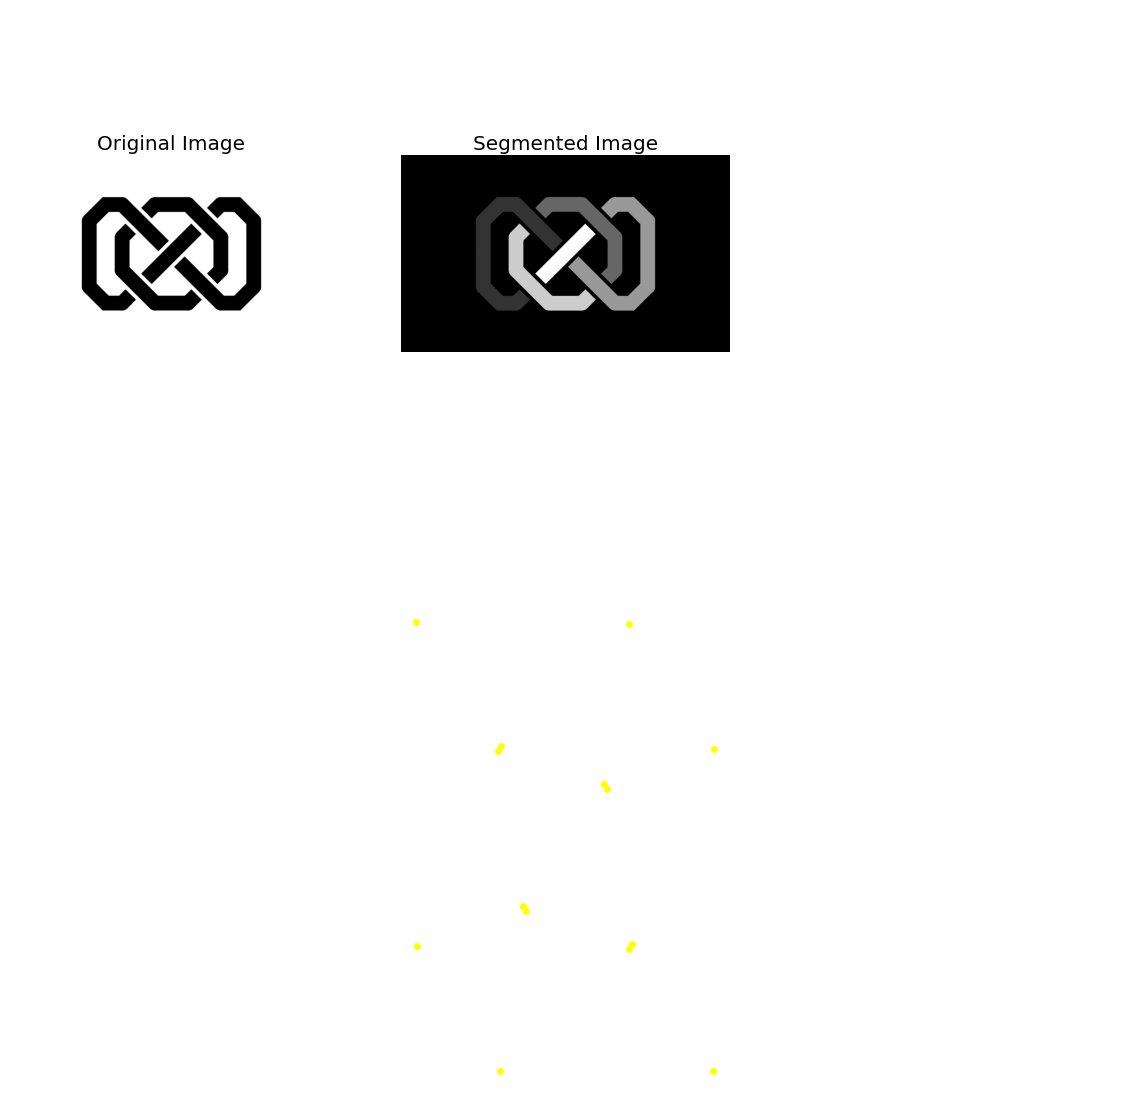

In [ ]:
figure, axs = plt.subplots(3, 3, figsize=(20, 20))
image = imread('celtic_knot_simple.png')

def x():
    for ax in axs.ravel():
        ax.axis("off")

    # print(image.shape)

    # Convert to binary image
    grayscale = (rgb2gray(image) * 255).astype(np.uint8)
    axs[0, 0].imshow(grayscale, cmap='gray')
    axs[0, 0].set_title('Original Image', fontsize=20)

    threshold = 127
    bin_image = np.zeros_like(grayscale)
    bin_image[grayscale > threshold] = 0
    bin_image[grayscale < threshold] = 1

    # labeling initial components
    labeled, _ = label(bin_image)
    axs[0, 1].imshow(labeled, cmap='gray')
    axs[0, 1].set_title('Segmented Image', fontsize=20)

    # Skeletonization and trimming
    # THIS IS TO FIX THE OFFSHOOT ISSUE
    skeleton, distance = medial_axis(bin_image, return_distance=True)

    labeled_skeleton, _ = label(skeleton, structure=[[1, 1, 1], [1, 1, 1], [1, 1, 1]])
    vals, _ = np.unique(labeled_skeleton, return_counts=True)
    print("segment count pre-trim:", vals.size - 1) # MINUS 1 IS BECAUSE BLACK IS ALSO A SEGMENT


    # trim method 1
    medial_axis_trimmed_skeleton, medial_axis_mode, dist_on_skel = medial_axis_trim(skeleton, distance)

    labeled_skeleton, _ = label(medial_axis_trimmed_skeleton, structure=[[1, 1, 1], [1, 1, 1], [1, 1, 1]])
    vals, _ = np.unique(labeled_skeleton, return_counts=True)
    print("segment count post-trim 1:", vals.size - 1) # MINUS 1 IS BECAUSE BLACK IS ALSO A SEGMENT
   

    # trim method 2
    path_cut_skeleton = path_trim(medial_axis_trimmed_skeleton)

    labeled_skeleton, _ = label(path_cut_skeleton, structure=[[1, 1, 1], [1, 1, 1], [1, 1, 1]])
    vals, _ = np.unique(labeled_skeleton, return_counts=True)
    print("segment count post-trim 2:", vals.size - 1) # MINUS 1 IS BECAUSE BLACK IS ALSO A SEGMENT
    

    # VISUALIZATION
    axs[0, 2].imshow(skeleton, cmap='gray')
    axs[0, 2].set_title('Adaptive Thinning Result', fontsize=20)

    axs[1, 0].imshow(dist_on_skel, cmap='gray')
    axs[1, 0].set_title('Medial Axis Information', fontsize=20)

    axs[1, 1].imshow(medial_axis_trimmed_skeleton, cmap='gray')
    axs[1, 1].set_title('Medial Axis Trimming Result', fontsize=20)

    axs[1, 2].imshow(path_cut_skeleton, cmap='gray')
    axs[1, 2].set_title('Tree Based Trimming Result', fontsize=20)



    # Gradient estimation
    blurred = gaussian(path_cut_skeleton, sigma=2)

    gx, gy = compute_gradients(blurred)

    gradient_direction = np.arctan2(gy, gx)

    y, x = np.nonzero((gx != 0) | (gy != 0))

    # just rotate each gradient on the old 1 pixel line by 90 now that they are reasonable.

    # Gradient visualization
    axs[2, 0].imshow(blurred, cmap='gray')

    flood_control = 10
    display_scaling = 10
    axs[2, 1].quiver((x)[::flood_control],
                     (y[::-1])[::flood_control],  # flip y coordinates so the image isn't upside-down
                     display_scaling * (gx[(gx != 0) | (gy != 0)])[::flood_control],
                     display_scaling * (gy[(gx != 0) | (gy != 0)])[::flood_control])

    fixed_endpoint_directions = fix_endpoint_gradients(path_cut_skeleton, gradient_direction)
    extensions = construct_endpoint_vectors(path_cut_skeleton, fixed_endpoint_directions, medial_axis_mode)
    print(extensions)



x()